# PF Optimization: HRP vs Markowitz and Equal-Weighted

## Imports & Settings

In [236]:
from collections import defaultdict
from time import time
import warnings

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_risk_parity import HRPOpt
from pypfopt import risk_models
from pypfopt import expected_returns

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [237]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [238]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [239]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [240]:
N_LONGS = 25
MIN_POSITIONS = 20

## Load Data

### Quandl Wiki Bundel

In [241]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [242]:
def load_predictions(bundle):
    path = Path('../../12_gradient_boosting_machines/data')
    predictions = (pd.read_hdf(path / 'predictions.h5', 'lgb/train/01')
                   .append(pd.read_hdf(path / 'predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))
    predictions = (predictions.loc[~predictions.index.duplicated()]
                   .iloc[:, :10]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [243]:
predictions, assets = load_predictions(bundle_data)

In [244]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2015-01-02 to 2017-12-28
Columns: 995 entries, 0 to 3188
dtypes: float64(995)
memory usage: 5.7 MB


### Define Custom Dataset

In [245]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [246]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [247]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [248]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0)
    },
            screen=StaticAssets(assets))

## Initialize Algorithm

In [249]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=1))

    schedule_function(rebalance_markowitz,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [250]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')['longs'].astype(int)
    context.longs = output[output!=0].index
    if len(context.longs) < MIN_POSITIONS:
        context.divest = set(context.portfolio.positions.keys())
    else:
        context.divest = context.portfolio.positions.keys() - context.longs

## Define Rebalancing Logic

In [251]:
def optimize_weights(prices, short=False):
    returns = expected_returns.mean_historical_return(prices=prices, 
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # get weights that maximize the Sharpe ratio
    ef = EfficientFrontier(expected_returns=returns, 
                           cov_matrix=cov, 
                           weight_bounds=(0, 1), 
                           gamma=0)
    
    weights = ef.max_sharpe()
    if short:
        return {asset: -weight for asset, weight in ef.clean_weights().items()}
    else:
        return ef.clean_weights()

In [252]:
def rebalance_equal_weighted(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        for asset in context.longs:
            order_target_percent(asset, 1/len(context.longs))

In [253]:
def rebalance_markowitz(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        prices = data.history(context.longs, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
        markowitz_weights = optimize_weights(prices)
        for asset, target in markowitz_weights.items():
            order_target_percent(asset=asset, target=target)

In [254]:
def rebalance_hierarchical_risk_parity(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        returns = (data.history(context.longs, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
                   .pct_change()
                   .dropna(how='all'))
        hrp_weights = HRPOpt(returns=returns).hrp_portfolio()
        for asset, target in hrp_weights.items():
            order_target_percent(asset=asset, target=target)

## Record Data Points

In [255]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs)

## Run Algorithm

In [256]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [257]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2015-01-02
End:   2017-12-28


In [258]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-03-02 22:30:31.932539]: WARNING: _load_cached_data: Refusing to download new benchmark data because a download succeeded at 2020-03-02 22:15:29.704986+00:00.
[2020-03-02 22:30:31.969983]: WARNING: _load_cached_data: Refusing to download new treasury data because a download succeeded at 2020-03-02 22:15:30.344988+00:00.


Duration: 25.35s


## PyFolio Analysis

In [259]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [260]:
experiment = 'markowitz'
with pd.HDFStore('backtests.h5') as store:
    store.put('returns/{}'.format(experiment), returns)
    store.put('positions/{}'.format(experiment), positions)
    store.put('transactions/{}'.format(experiment), transactions)

In [261]:
experiment = 'hrp'
with pd.HDFStore('backtests.h5') as store:
    returns = store.get('returns/{}'.format(experiment))
    positions = store.get('positions/{}'.format(experiment))
    transactions = store.get('transactions/{}'.format(experiment))

In [262]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

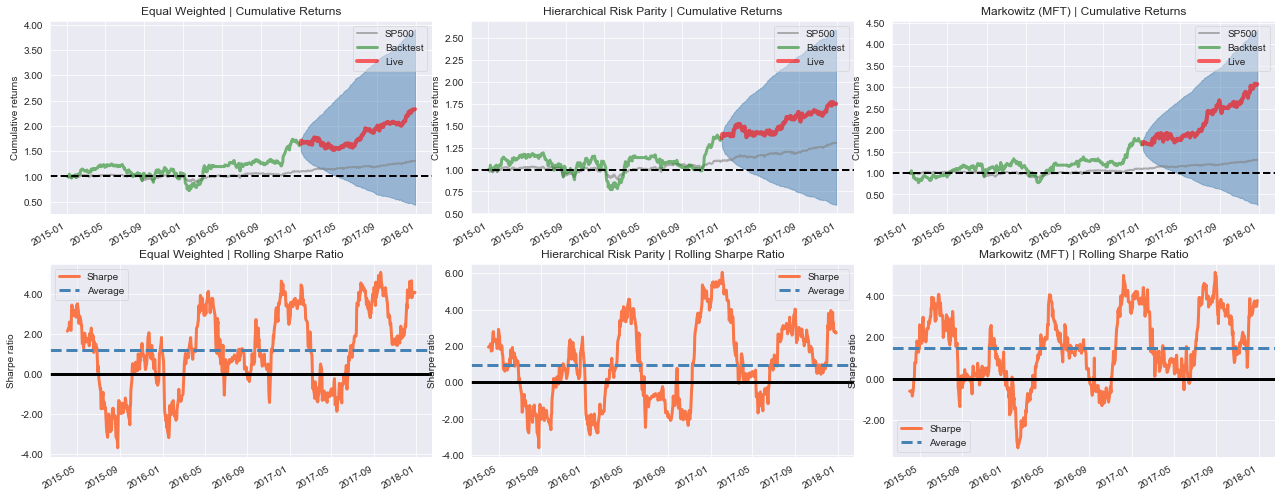

In [276]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
exp_dict = {'ew': 'Equal Weighted', 'hrp': 'Hierarchical Risk Parity', 'markowitz': 'Markowitz (MFT)'}
for i, experiment in enumerate(['ew', 'hrp', 'markowitz']):
    returns = pd.read_hdf('backtests.h5', 'returns/{}'.format(experiment))    
    plot_rolling_returns(returns,
                         factor_returns=benchmark,
                         live_start_date='2017-01-01',
                         logy=False,
                         cone_std=2,
                         legend_loc='best',
                         volatility_match=False,
                         cone_function=forecast_cone_bootstrap,
                        ax=axes[0][i])
    plot_rolling_sharpe(returns, ax=axes[1][i], rolling_window=63)
    axes[0][i].set_title('{} | Cumulative Returns'.format(exp_dict[experiment]))
    axes[1][i].set_title('{} | Rolling Sharpe Ratio'.format(exp_dict[experiment]))
    fig.tight_layout()
    fig.savefig('../figures/pf_optimization', dpi=300);

### Tear Sheets

#### Equal Weighted

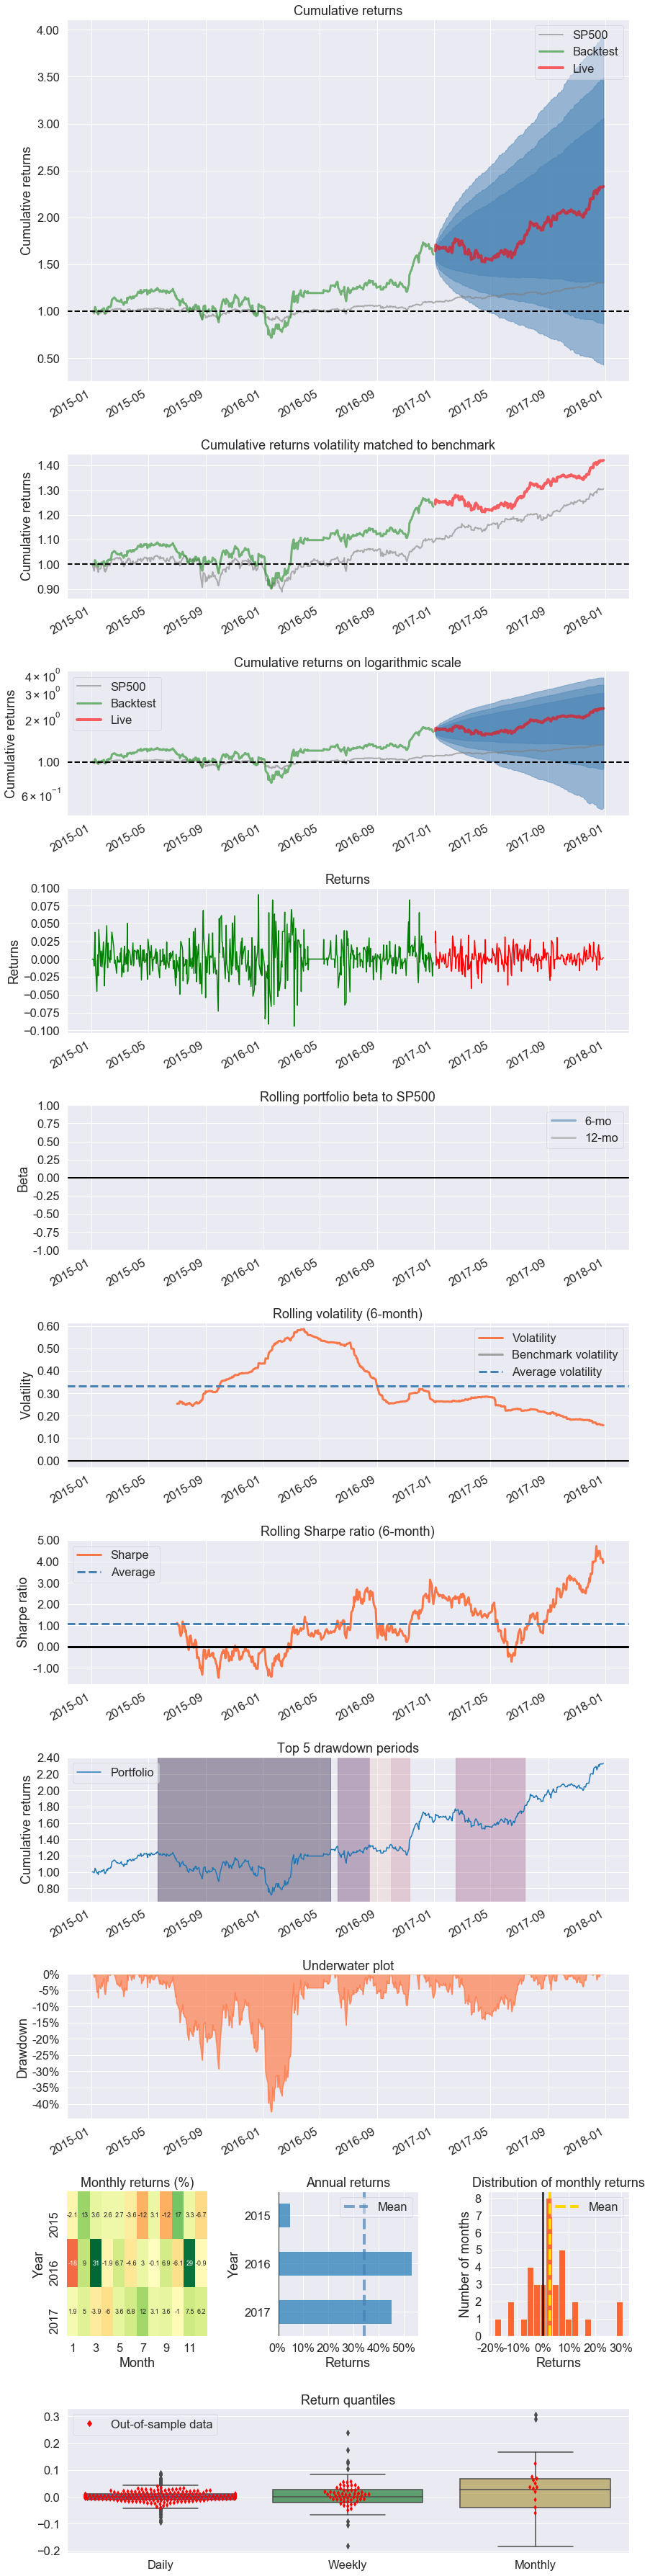

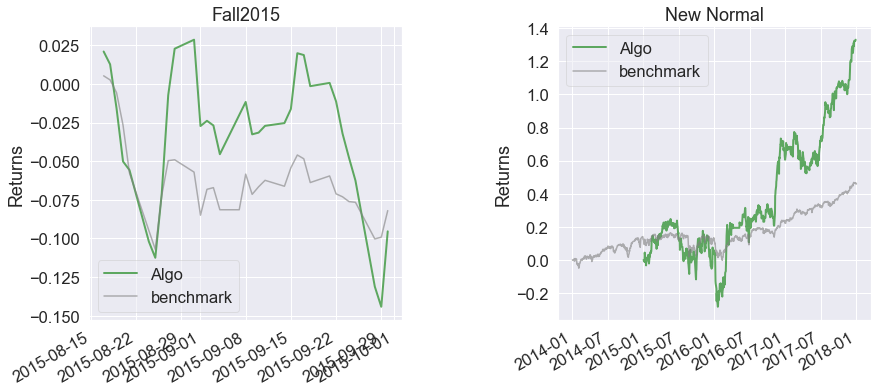

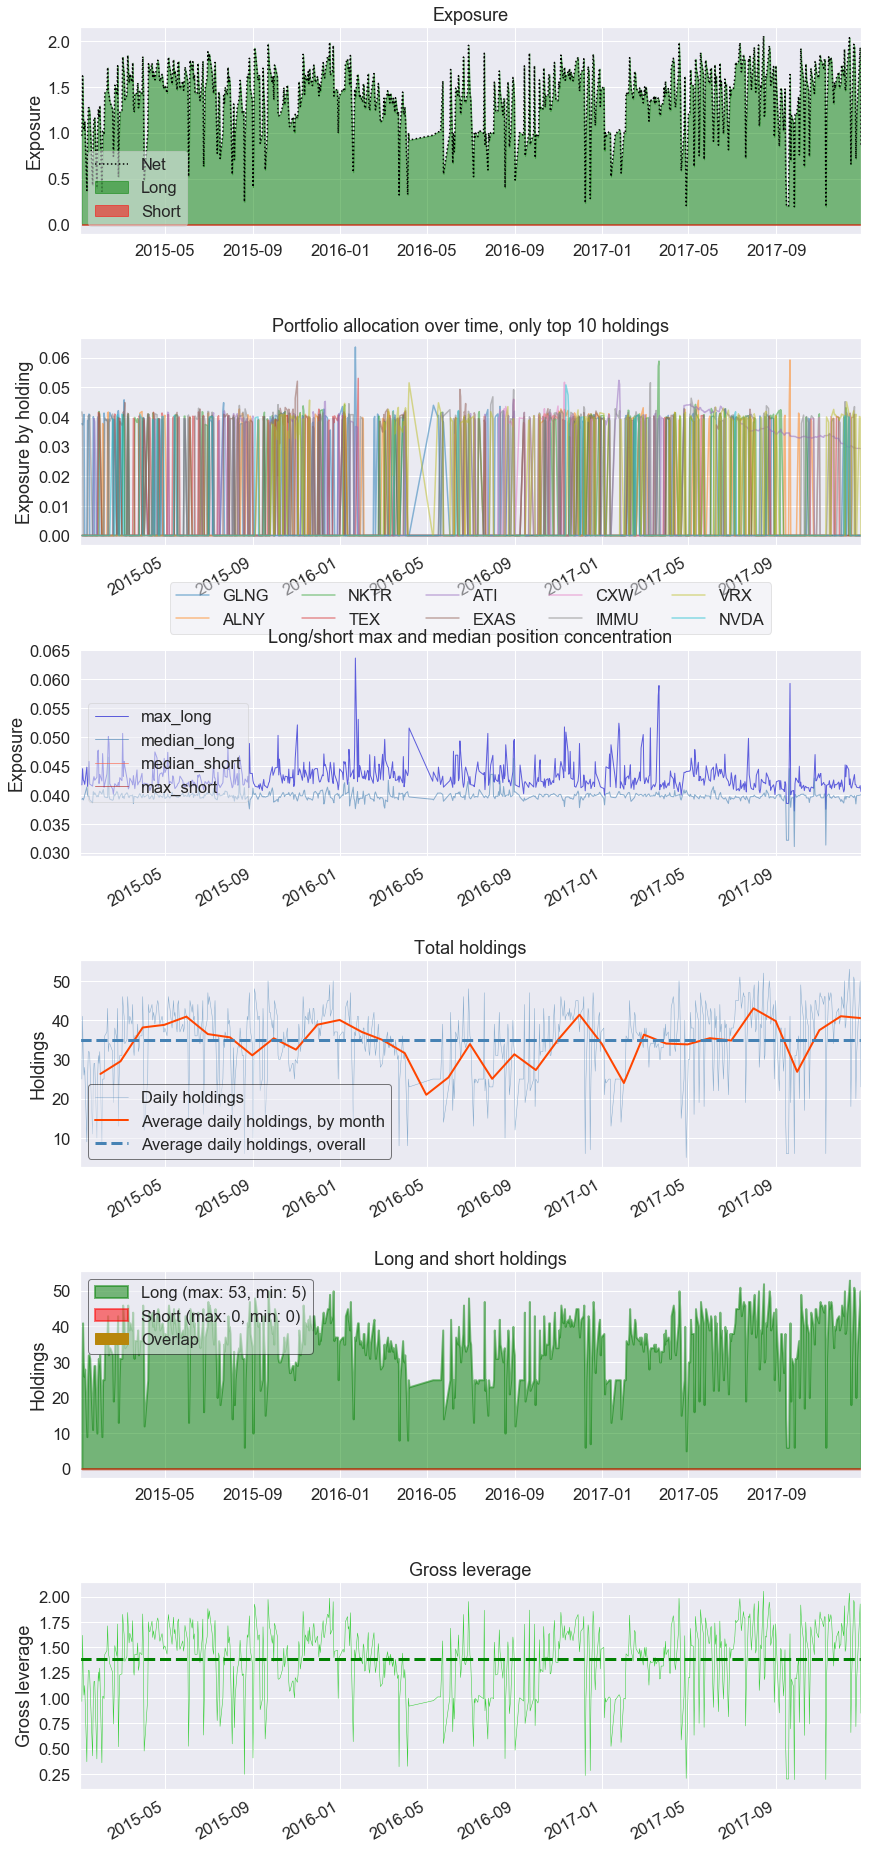

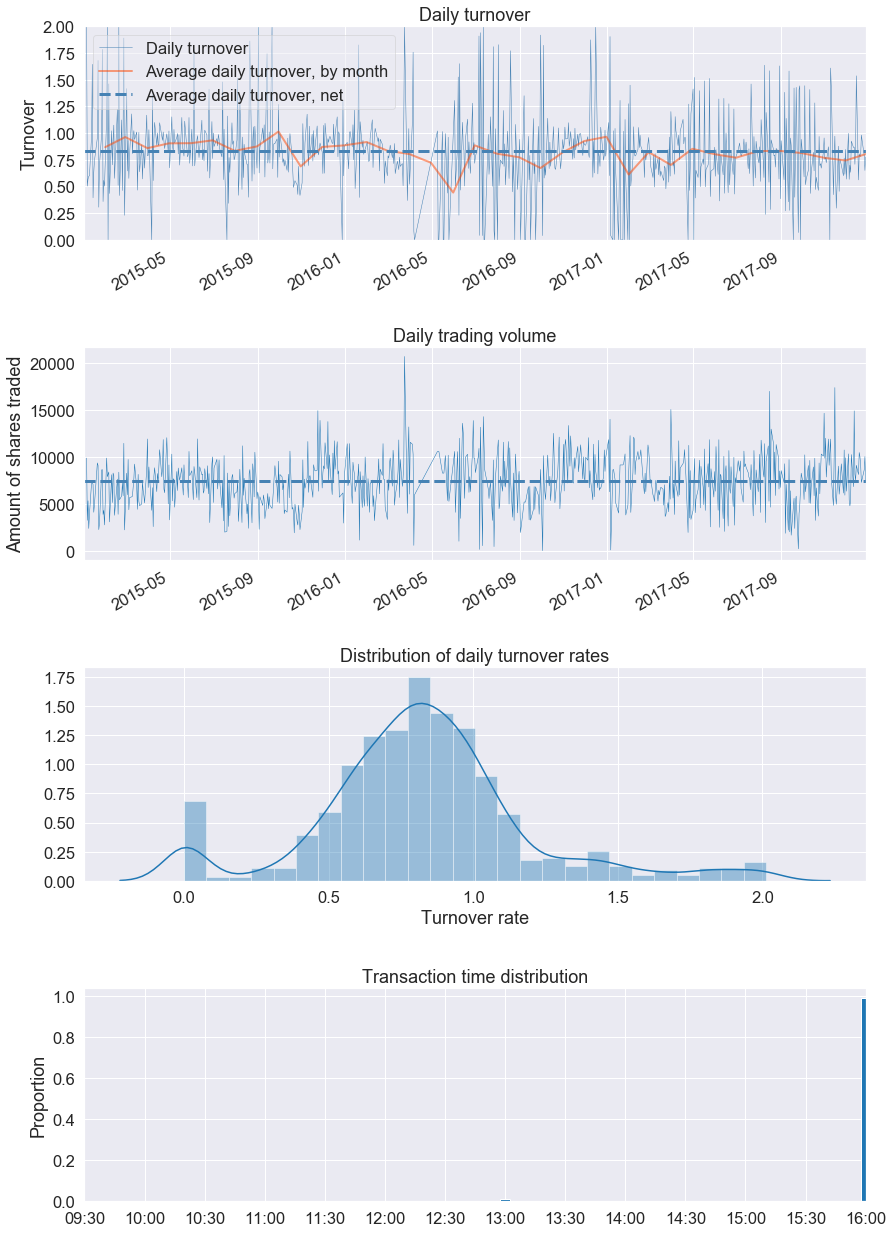

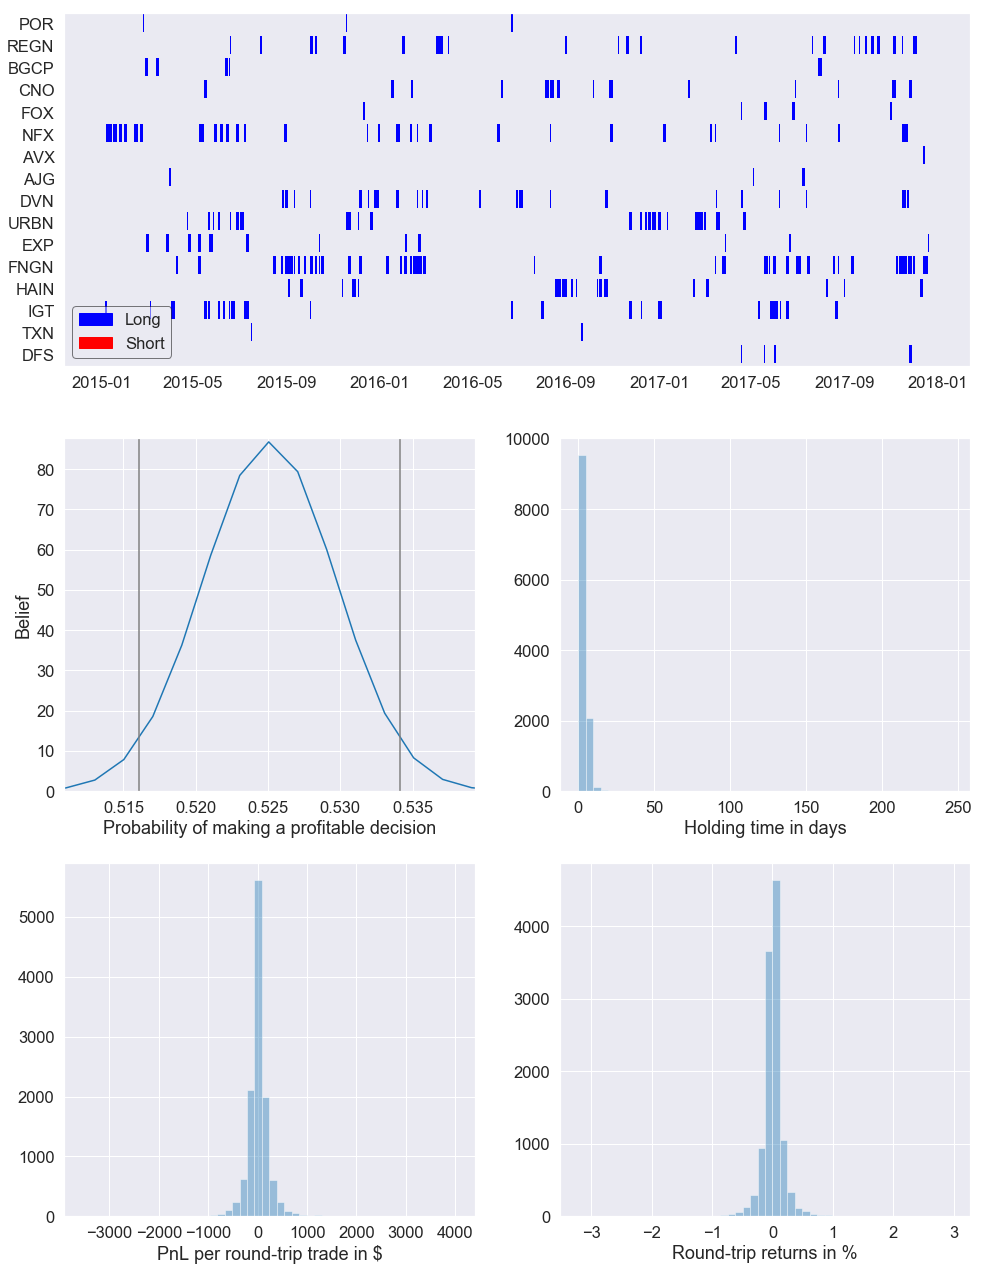

In [277]:
experiment = 'ew'
with pd.HDFStore('backtests.h5') as store:
    returns = store.get('returns/{}'.format(experiment))
    positions = store.get('positions/{}'.format(experiment))
    transactions = store.get('transactions/{}'.format(experiment))

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)

#### HRP

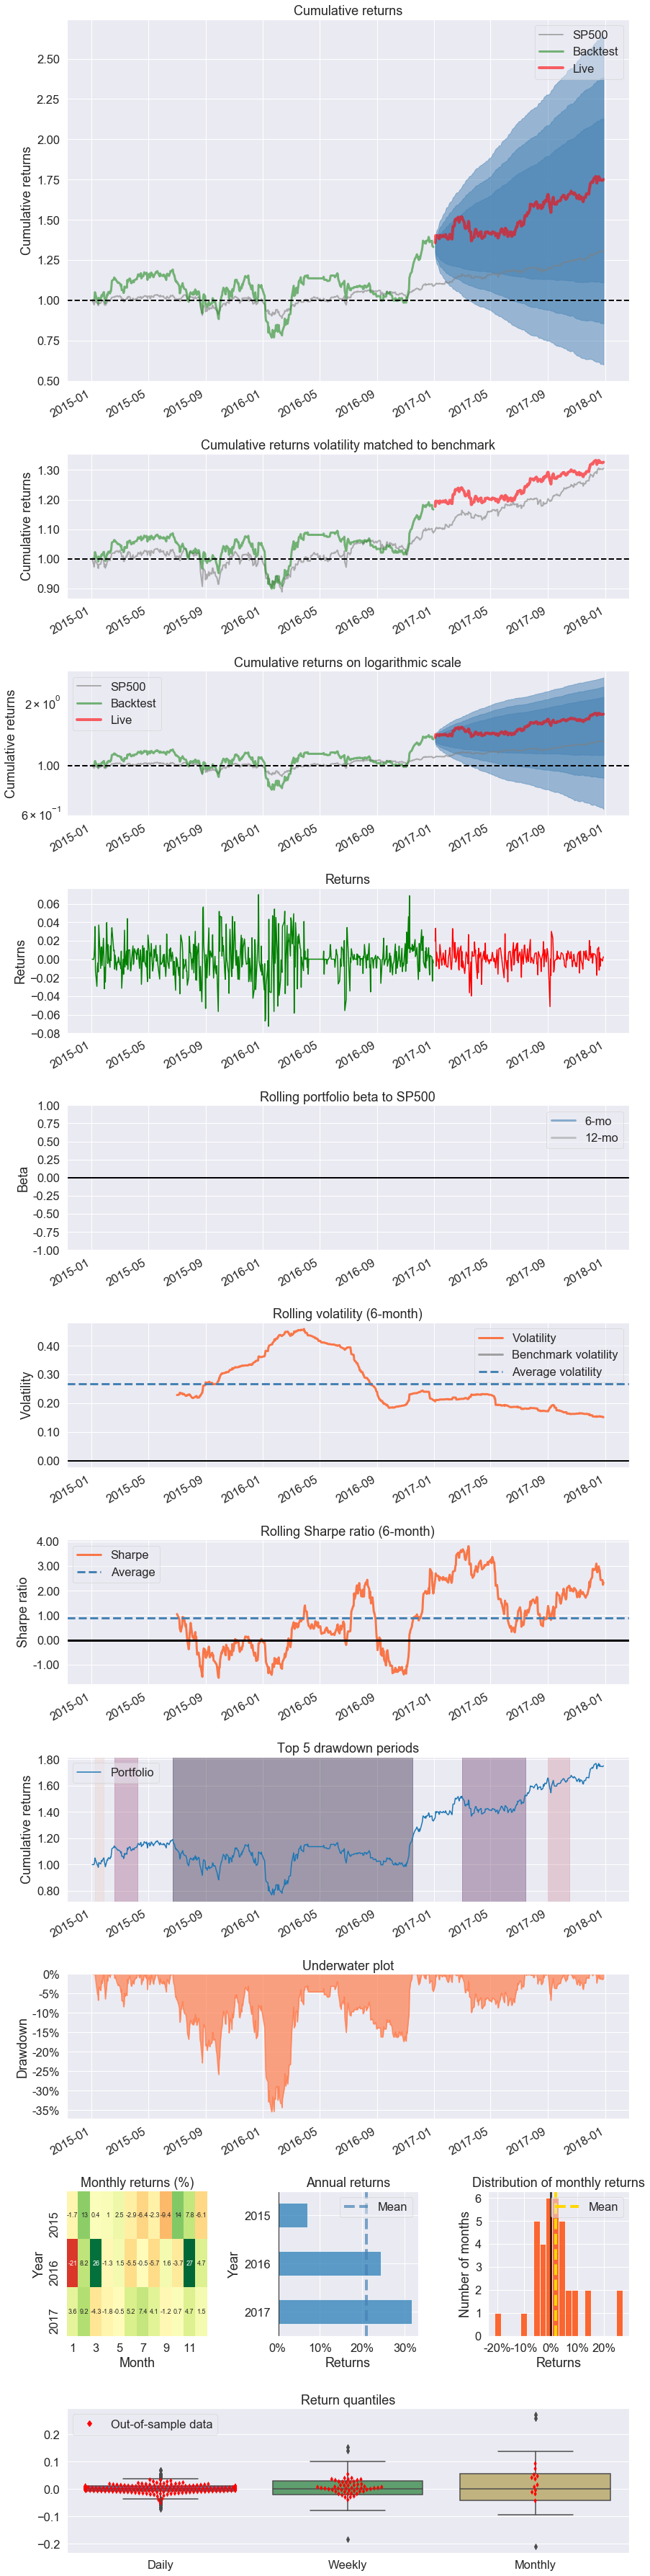

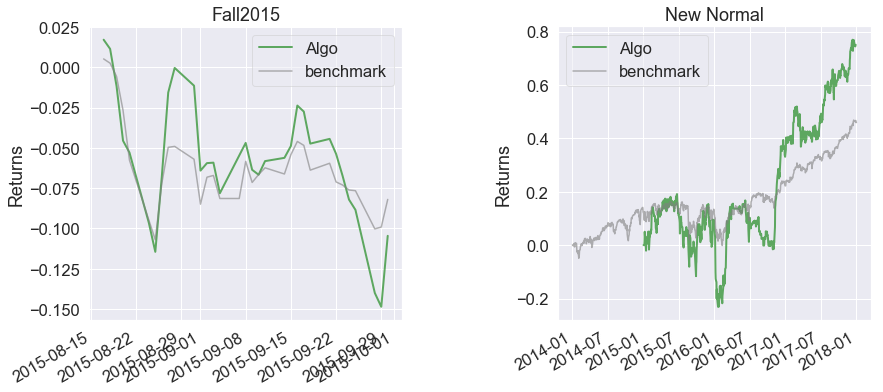

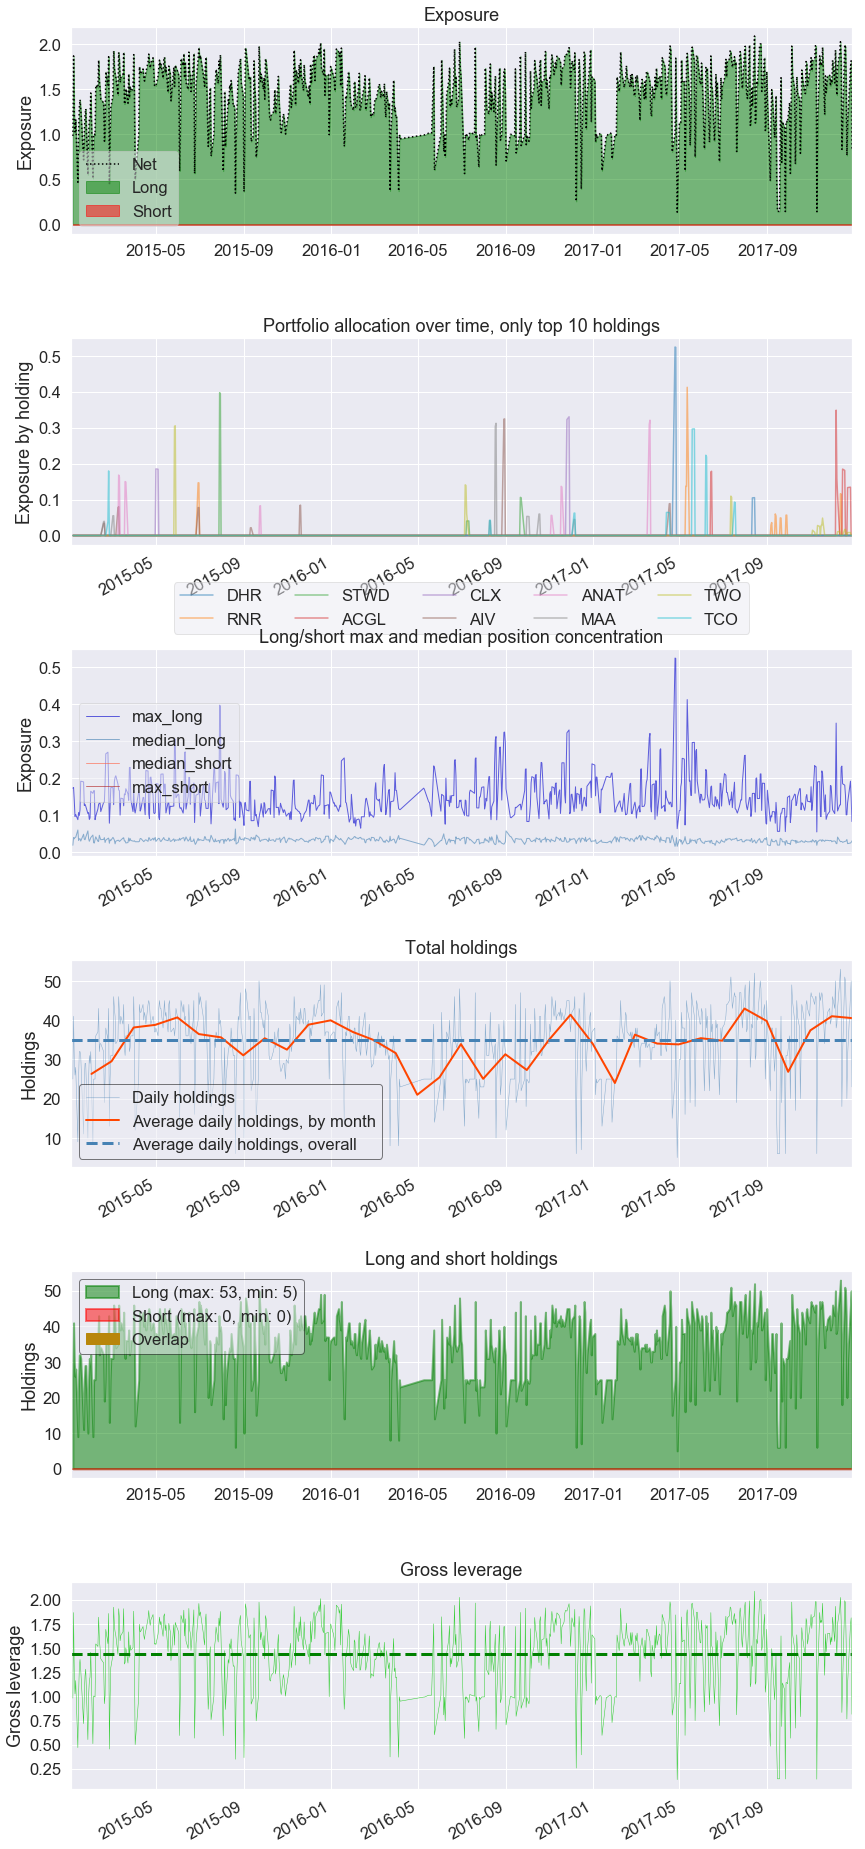

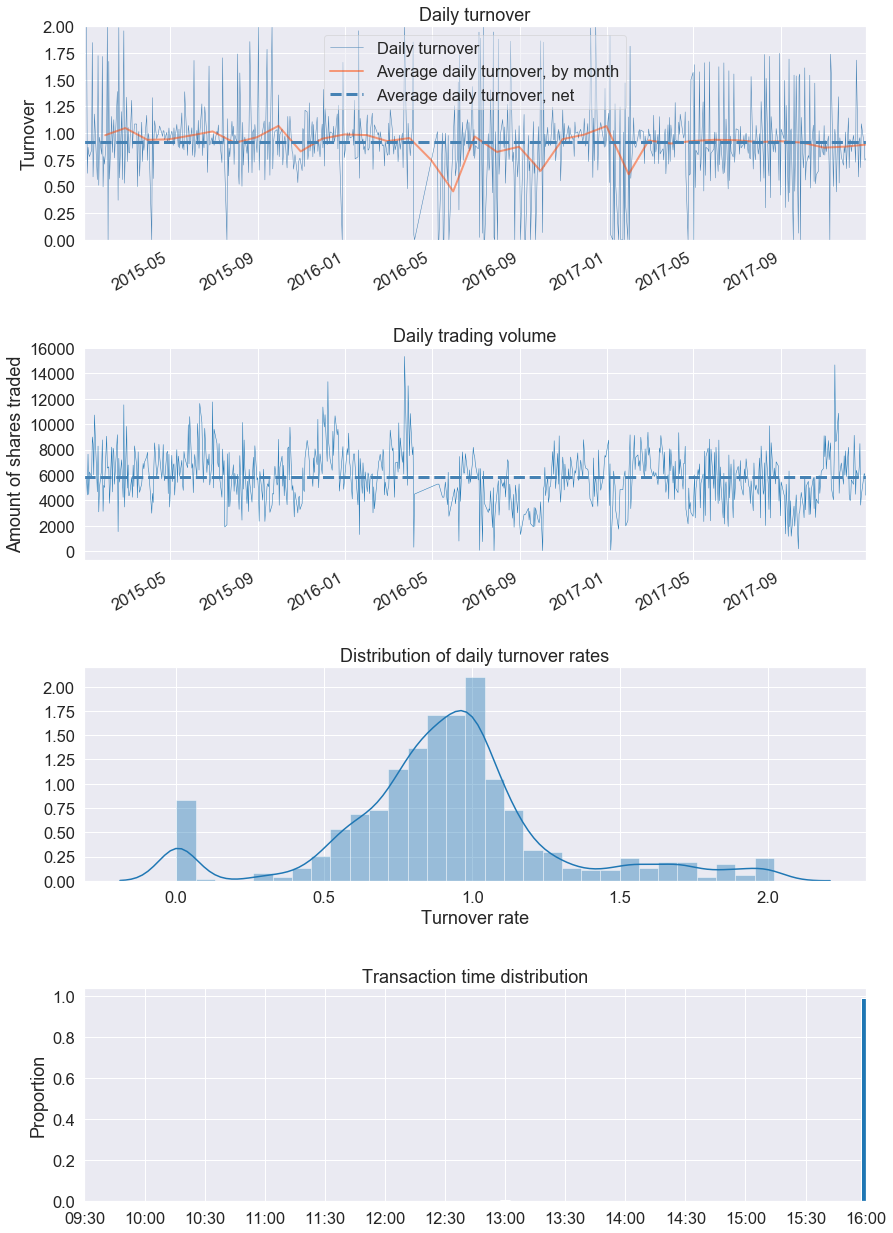

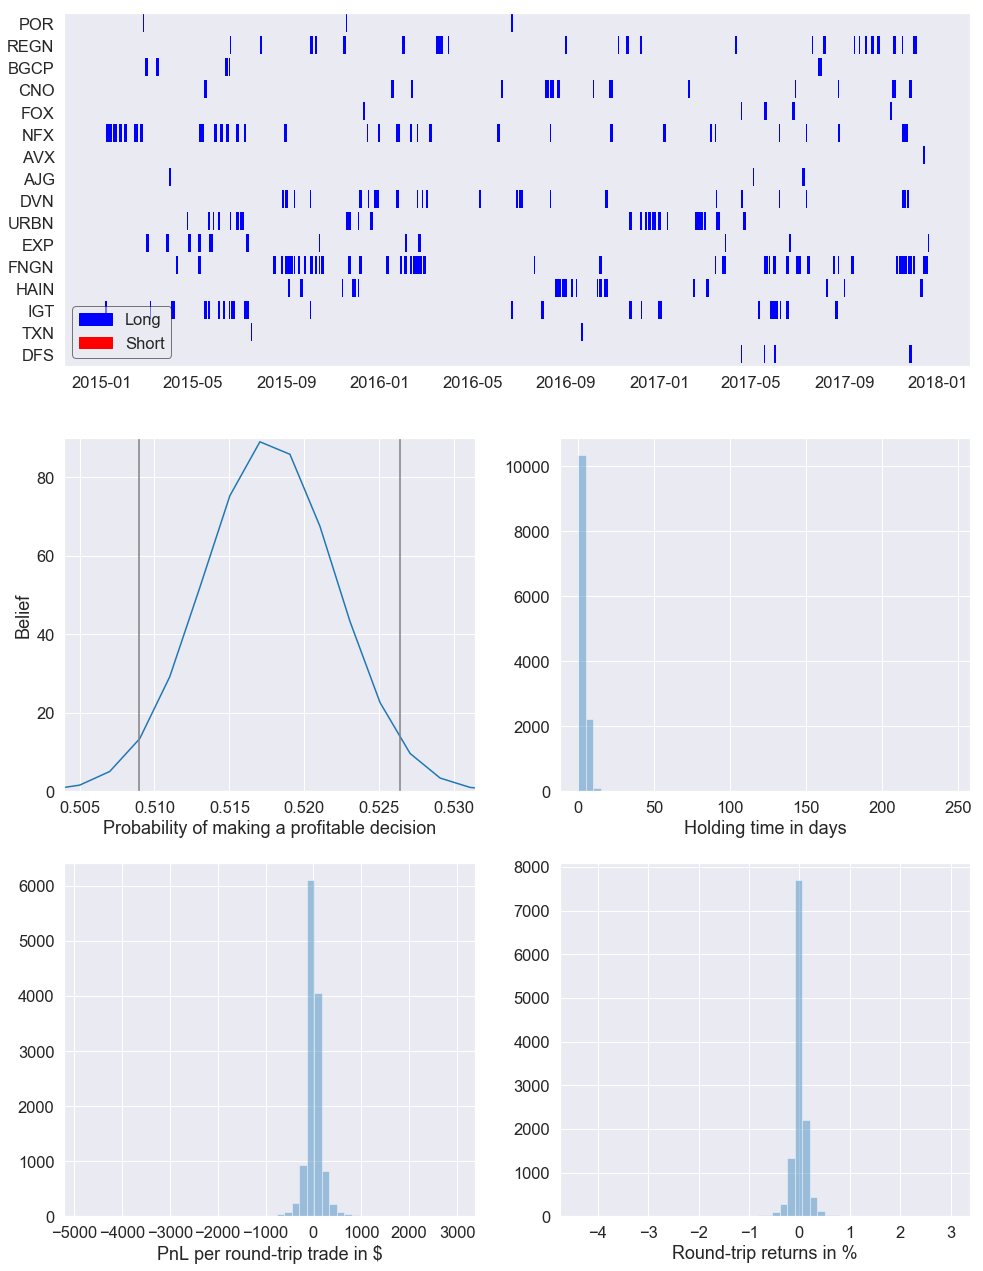

In [278]:
experiment = 'hrp'
with pd.HDFStore('backtests.h5') as store:
    returns = store.get('returns/{}'.format(experiment))
    positions = store.get('positions/{}'.format(experiment))
    transactions = store.get('transactions/{}'.format(experiment))

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)

#### Markowitz

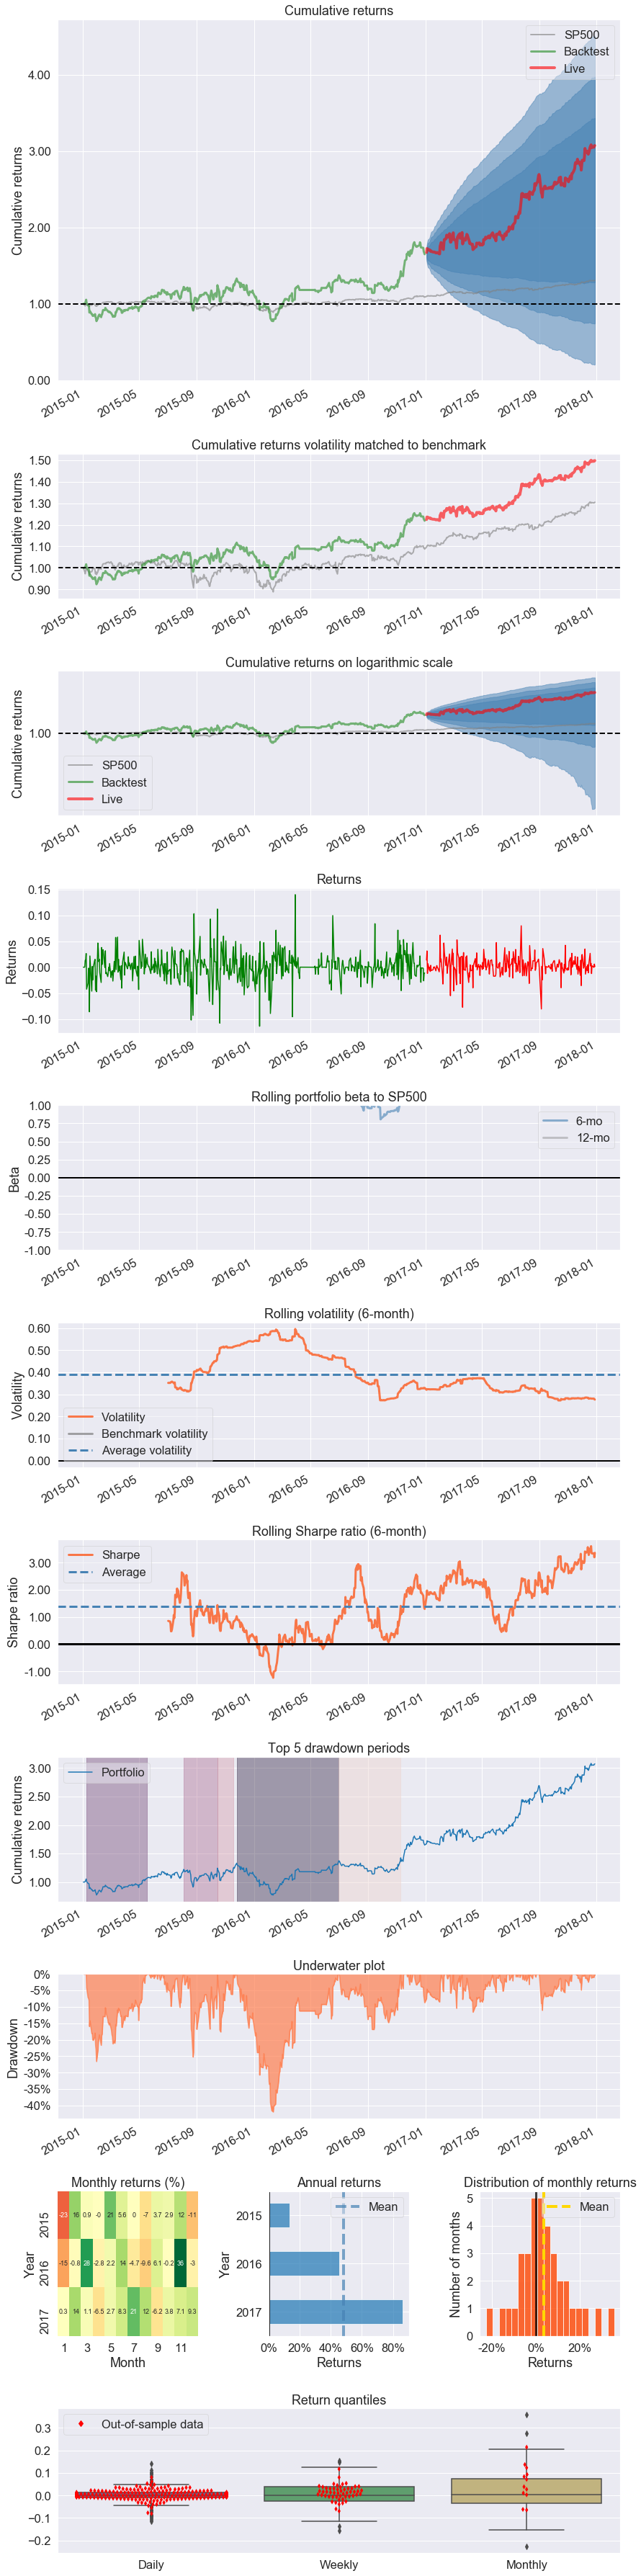

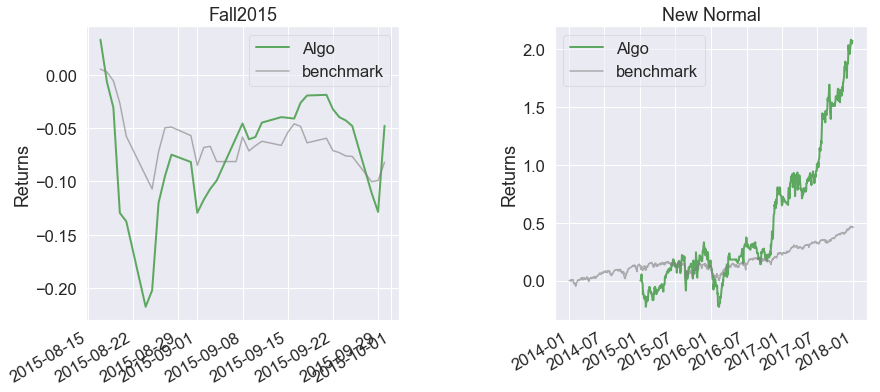

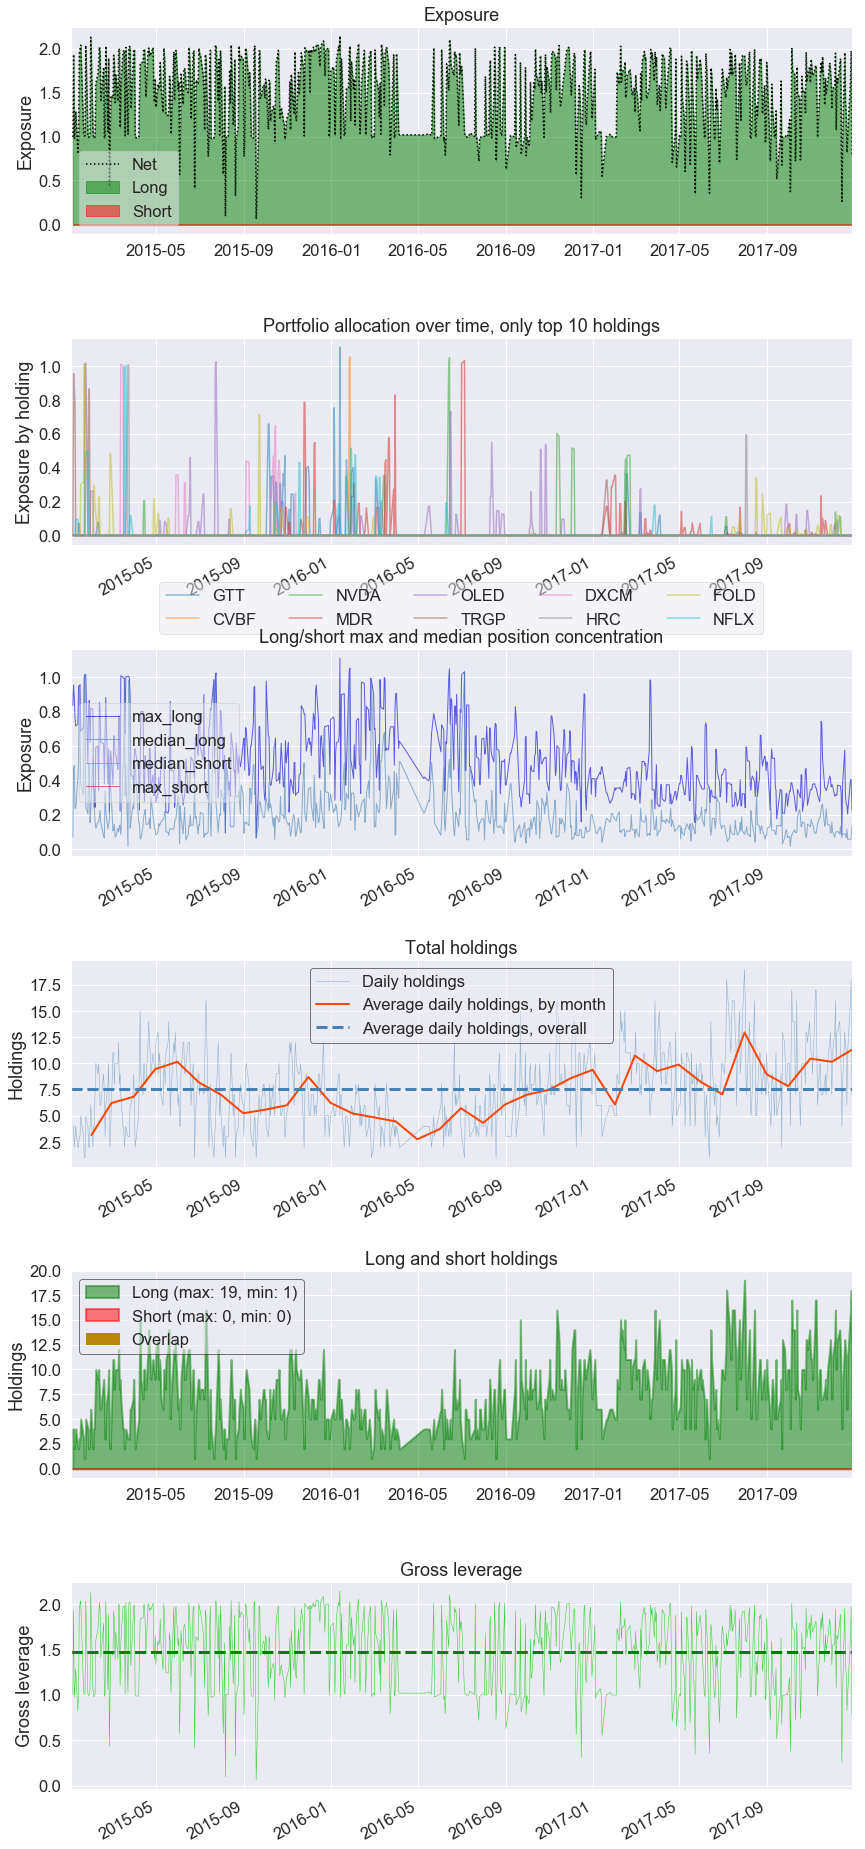

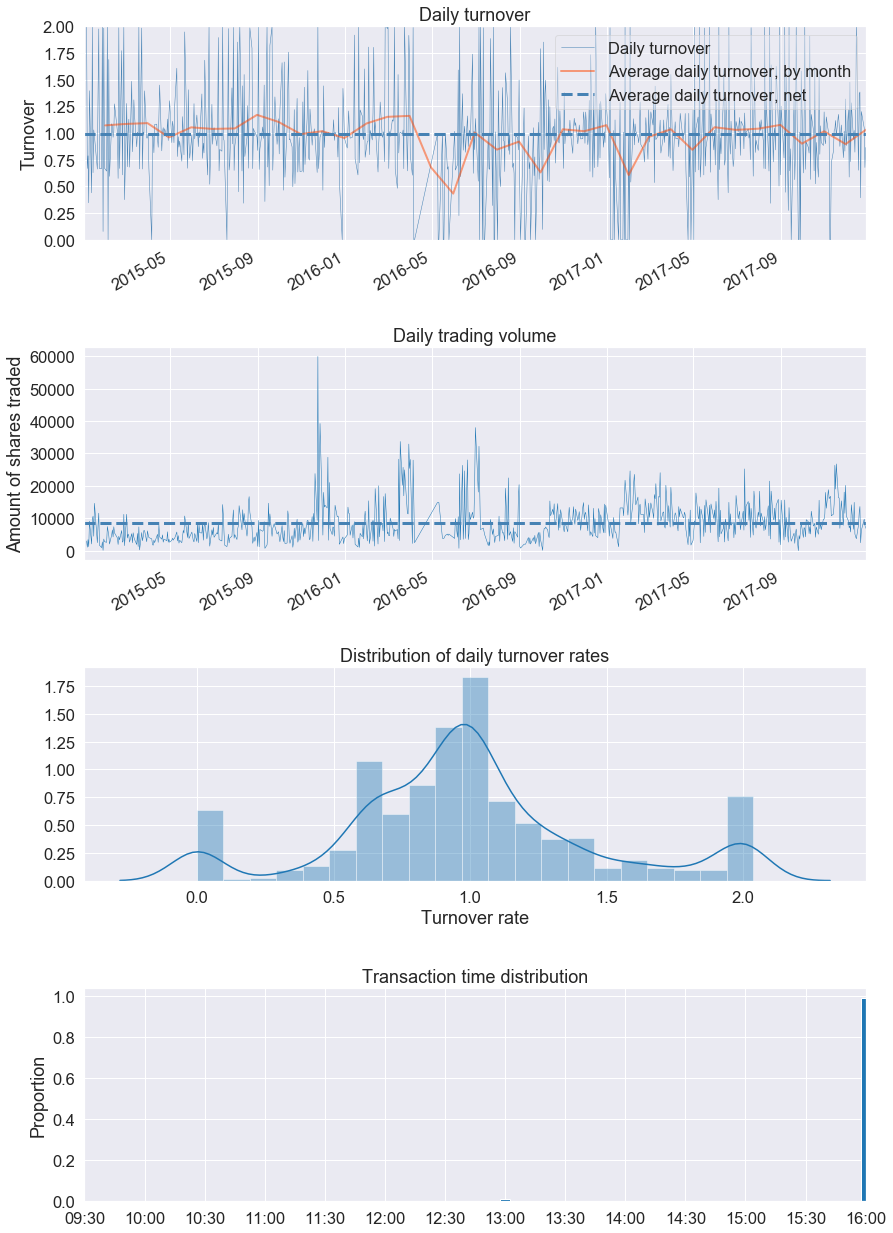

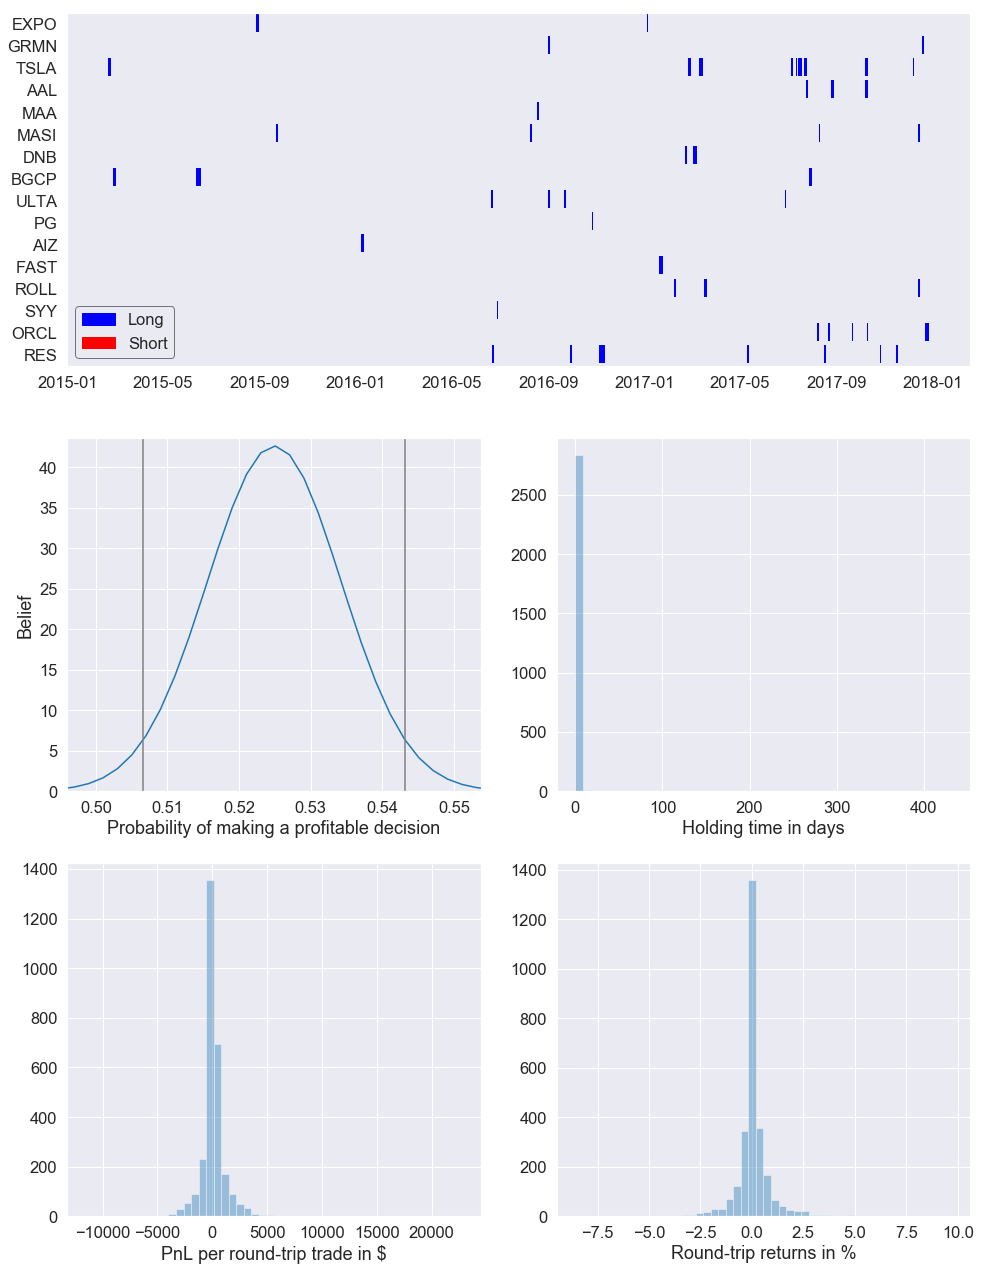

In [279]:
experiment = 'markowitz'
with pd.HDFStore('backtests.h5') as store:
    returns = store.get('returns/{}'.format(experiment))
    positions = store.get('positions/{}'.format(experiment))
    transactions = store.get('transactions/{}'.format(experiment))

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)